In [1]:
import pickle

path = "sample2_undersampling"

pik_file1 = open(f"{path}/train_v.pkl", 'rb')
pik_file2 = open(f"{path}/test_v.pkl", 'rb')
pik_file3 = open(f"{path}/train_v_resample.pkl", 'rb')
pik_file4 = open(f"{path}/test_v_resample.pkl", 'rb')
train_v = pickle.load(pik_file1)
test_v = pickle.load(pik_file2)
train_v_resample = pickle.load(pik_file3)
test_v_resample = pickle.load(pik_file4)

In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
import numpy as np
import utils.plot as plot
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve

## XGBoost Classifier default parameters

In [6]:
%%time
from xgboost import XGBClassifier
xg_clf = XGBClassifier(random_state = 121,
                       eval_metric='logloss',
                       n_jobs=-1).fit(train_v_resample[0], train_v_resample[1])
print(xg_clf)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=121,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
Wall time: 1.87 s


In [7]:
print('XGboost test acc is : ', accuracy_score(test_v_resample[1], xg_clf.predict(test_v_resample[0])))
print('XGboost test precision is : ', precision_score(test_v_resample[1], xg_clf.predict(test_v_resample[0]),average='macro'))
print('XGboost test recall is : ', recall_score(test_v_resample[1], xg_clf.predict(test_v_resample[0]),average='macro'))
print('XGboost test f1 is : ', f1_score(test_v_resample[1], xg_clf.predict(test_v_resample[0]),average='macro'))
print('XGboost test auc is : ', roc_auc_score(test_v_resample[1], np.max(xg_clf.predict_proba(test_v_resample[0]),1)))

XGboost test acc is :  0.7505223568742164
XGboost test precision is :  0.7514842989230517
XGboost test recall is :  0.7505223568742165
XGboost test f1 is :  0.7502835619045921
XGboost test auc is :  0.4801567253982355


In [8]:
print('XGboost test acc is : ', accuracy_score(test_v_resample[1], xg_clf.predict(test_v_resample[0])))
print('XGboost test precision is : ', precision_score(test_v_resample[1], xg_clf.predict(test_v_resample[0])))
print('XGboost test recall is : ', recall_score(test_v_resample[1], xg_clf.predict(test_v_resample[0])))
print('XGboost test f1 is : ', f1_score(test_v_resample[1], xg_clf.predict(test_v_resample[0])))
print('XGboost test auc is : ', roc_auc_score(test_v_resample[1], np.max(xg_clf.predict_proba(test_v_resample[0]),1)))

XGboost test acc is :  0.7505223568742164
XGboost test precision is :  0.7359307359307359
XGboost test recall is :  0.7814458838278312
XGboost test f1 is :  0.7580056749087961
XGboost test auc is :  0.4801567253982355


In [9]:
y_score = np.max(xg_clf.predict_proba(test_v_resample[0]),1)

xgb_prec, xgb_recall, _ = precision_recall_curve(test_v_resample[1], y_score, pos_label=1)
xgb_fpr, xgb_tpr, _ = roc_curve(test_v_resample[1], y_score, pos_label=1)

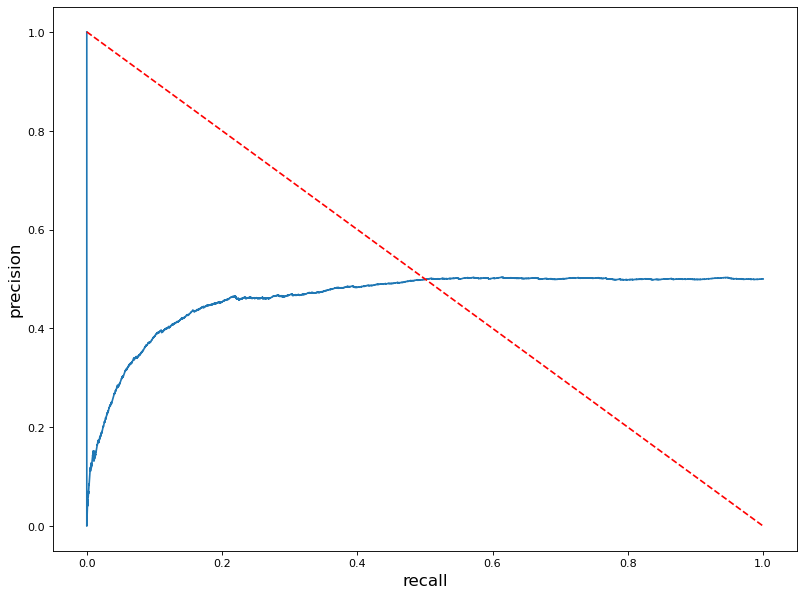

In [10]:
plot.pr_curve(xgb_prec, xgb_recall)

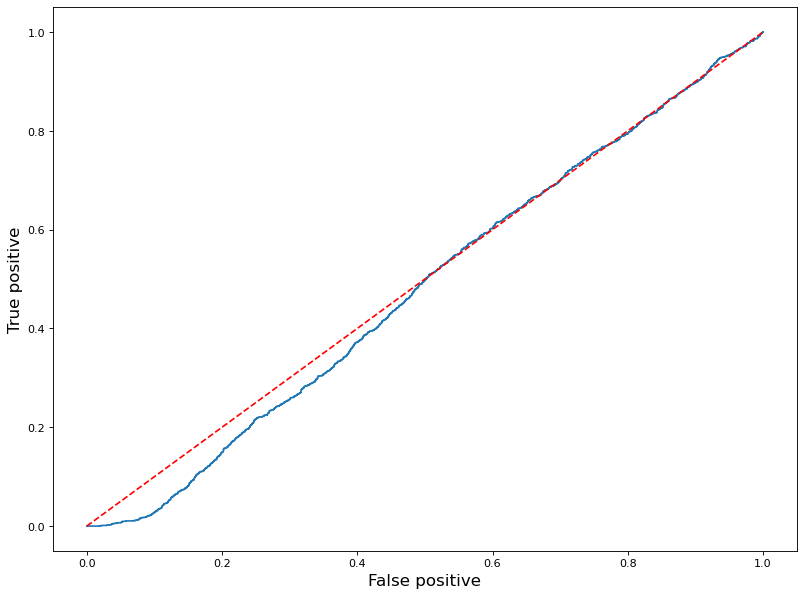

In [11]:
plot.roc_curve(xgb_fpr, xgb_tpr)

## XGBoost hyper parameter tuning

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
pipe_xgb = make_pipeline(XGBClassifier(random_state = 121, eval_metric='logloss',n_jobs=-1))
params = {'xgbclassifier__learning_rate': np.logspace(-2, 0, 3), 
          'xgbclassifier__n_estimators': np.linspace(100, 700, 7).astype(int),
          'xgbclassifier__max_depth': np.linspace(3, 7, 5).astype(int)
         }
grid = GridSearchCV(pipe_xgb, params, cv = 10, n_jobs = -1)
grid.fit(train_v_resample[0], train_v_resample[1])
grid.best_params_

{'xgbclassifier__learning_rate': 0.1,
 'xgbclassifier__max_depth': 6,
 'xgbclassifier__n_estimators': 200}

## Good model for undersampling dataset

In [15]:
%%time
best_learning_rate = grid.best_params_['xgbclassifier__learning_rate']
best_n_estimators = grid.best_params_['xgbclassifier__n_estimators']
best_max_depth = grid.best_params_['xgbclassifier__max_depth']
xg_clf = XGBClassifier(random_state = 121,
                       eval_metric='logloss', 
                       learning_rate = best_learning_rate,
                       n_estimators = best_n_estimators,
                       max_depth = best_max_depth,
                       n_jobs=-1)
xg_clf.fit(train_v_resample[0], train_v_resample[1])
print(xg_clf)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=121,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
Wall time: 7.53 s


In [16]:
print('XGboost test acc is : ', accuracy_score(test_v_resample[1], xg_clf.predict(test_v_resample[0])))
print('XGboost test precision is : ', precision_score(test_v_resample[1], xg_clf.predict(test_v_resample[0]),average='macro'))
print('XGboost test recall is : ', recall_score(test_v_resample[1], xg_clf.predict(test_v_resample[0]),average='macro'))
print('XGboost test f1 is : ', f1_score(test_v_resample[1], xg_clf.predict(test_v_resample[0]),average='macro'))
print('XGboost test auc is : ', roc_auc_score(test_v_resample[1], np.max(xg_clf.predict_proba(test_v_resample[0]),1)))

XGboost test acc is :  0.7524028416213957
XGboost test precision is :  0.7532328371597566
XGboost test recall is :  0.7524028416213957
XGboost test f1 is :  0.7521997942327765
XGboost test auc is :  0.477565590822515


In [17]:
print('XGboost test acc is : ', accuracy_score(test_v_resample[1], xg_clf.predict(test_v_resample[0])))
print('XGboost test precision is : ', precision_score(test_v_resample[1], xg_clf.predict(test_v_resample[0])))
print('XGboost test recall is : ', recall_score(test_v_resample[1], xg_clf.predict(test_v_resample[0])))
print('XGboost test f1 is : ', f1_score(test_v_resample[1], xg_clf.predict(test_v_resample[0])))
print('XGboost test auc is : ', roc_auc_score(test_v_resample[1], np.max(xg_clf.predict_proba(test_v_resample[0]),1)))

XGboost test acc is :  0.7524028416213957
XGboost test precision is :  0.7387351778656126
XGboost test recall is :  0.781027998328458
XGboost test f1 is :  0.7592931139549055
XGboost test auc is :  0.477565590822515


In [18]:
y_score = np.max(xg_clf.predict_proba(test_v_resample[0]),1)

xgb_prec, xgb_recall, _ = precision_recall_curve(test_v_resample[1], y_score, pos_label=1)
xgb_fpr, xgb_tpr, _ = roc_curve(test_v_resample[1], y_score, pos_label=1)

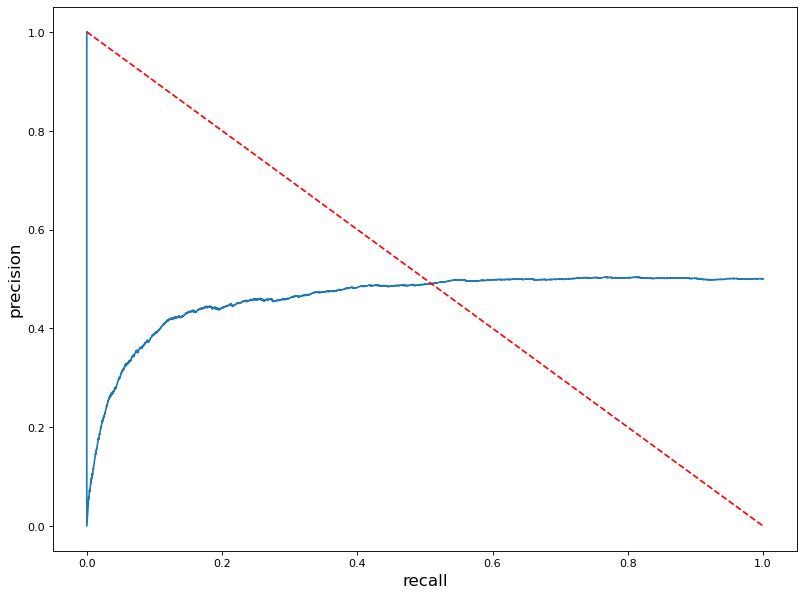

In [19]:
plot.pr_curve(xgb_prec, xgb_recall)

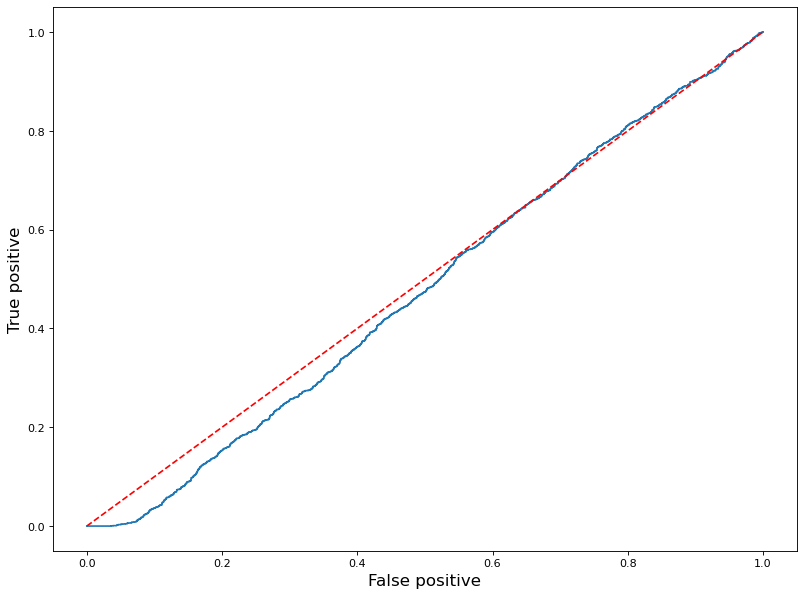

In [20]:
plot.roc_curve(xgb_fpr, xgb_tpr)

## Good model for oversampling dataset

In [1]:
import pickle

path = "sample1_oversampling"

pik_file1 = open(f"{path}/train_v.pkl", 'rb')
pik_file2 = open(f"{path}/test_v.pkl", 'rb')
pik_file3 = open(f"{path}/train_v_resample.pkl", 'rb')
pik_file4 = open(f"{path}/test_v_resample.pkl", 'rb')
train_v = pickle.load(pik_file1)
test_v = pickle.load(pik_file2)
train_v_resample = pickle.load(pik_file3)
test_v_resample = pickle.load(pik_file4)

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

In [22]:
%%time
best_learning_rate = 0.001
best_n_estimators = 200
best_max_depth = 2
xg_clf = XGBClassifier(random_state = 121,
                       eval_metric='logloss', 
                       learning_rate = best_learning_rate,
                       n_estimators = best_n_estimators,
                       max_depth = best_max_depth,
                       n_jobs=-1)
xg_clf.fit(train_v_resample[0], train_v_resample[1])
print(xg_clf)

C:\Users\SRIRAM\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.001, max_delta_step=0,
              max_depth=2, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=121,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
Wall time: 17.4 s


In [23]:
print('XGboost test acc is : ', accuracy_score(test_v_resample[1], xg_clf.predict(test_v_resample[0])))
print('XGboost test precision is : ', precision_score(test_v_resample[1], xg_clf.predict(test_v_resample[0]),average='macro'))
print('XGboost test recall is : ', recall_score(test_v_resample[1], xg_clf.predict(test_v_resample[0]),average='macro'))
print('XGboost test f1 is : ', f1_score(test_v_resample[1], xg_clf.predict(test_v_resample[0]),average='macro'))
print('XGboost test auc is : ', roc_auc_score(test_v_resample[1], np.max(xg_clf.predict_proba(test_v_resample[0]),1)))

XGboost test acc is :  0.6410684474123539
XGboost test precision is :  0.6452811017316452
XGboost test recall is :  0.6410684474123539
XGboost test f1 is :  0.6384475014037058
XGboost test auc is :  0.5656408426955333


In [14]:
print('XGboost test acc is : ', accuracy_score(test_v_resample[1], xg_clf.predict(test_v_resample[0])))
print('XGboost test precision is : ', precision_score(test_v_resample[1], xg_clf.predict(test_v_resample[0])))
print('XGboost test recall is : ', recall_score(test_v_resample[1], xg_clf.predict(test_v_resample[0])))
print('XGboost test f1 is : ', f1_score(test_v_resample[1], xg_clf.predict(test_v_resample[0])))
print('XGboost test auc is : ', roc_auc_score(test_v_resample[1], np.max(xg_clf.predict_proba(test_v_resample[0]),1)))

XGboost test acc is :  0.6410684474123539
XGboost test precision is :  0.670020120724346
XGboost test recall is :  0.5559265442404007
XGboost test f1 is :  0.6076642335766422
XGboost test auc is :  0.5656408426955333


In [15]:
y_score = np.max(xg_clf.predict_proba(test_v_resample[0]),1)

xgb_prec, xgb_recall, _ = precision_recall_curve(test_v_resample[1], y_score, pos_label=1)
xgb_fpr, xgb_tpr, _ = roc_curve(test_v_resample[1], y_score, pos_label=1)

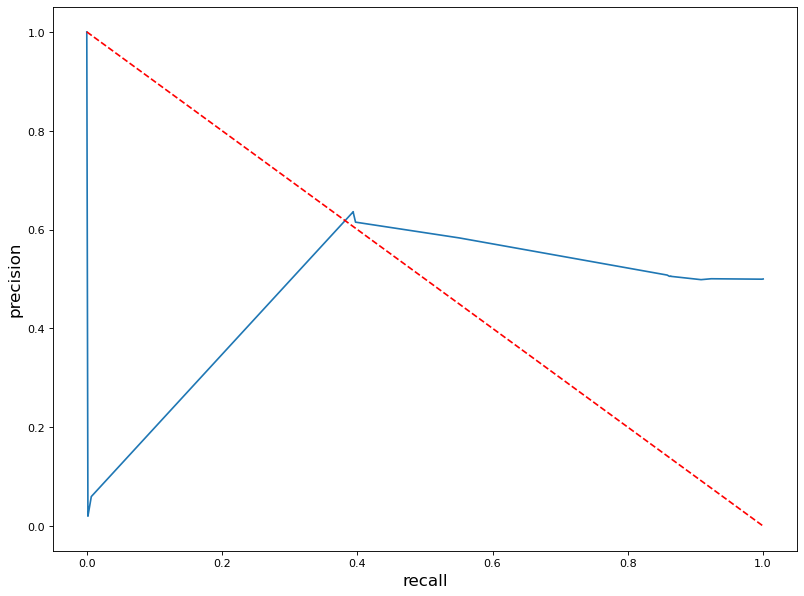

In [16]:
plot.pr_curve(xgb_prec, xgb_recall)

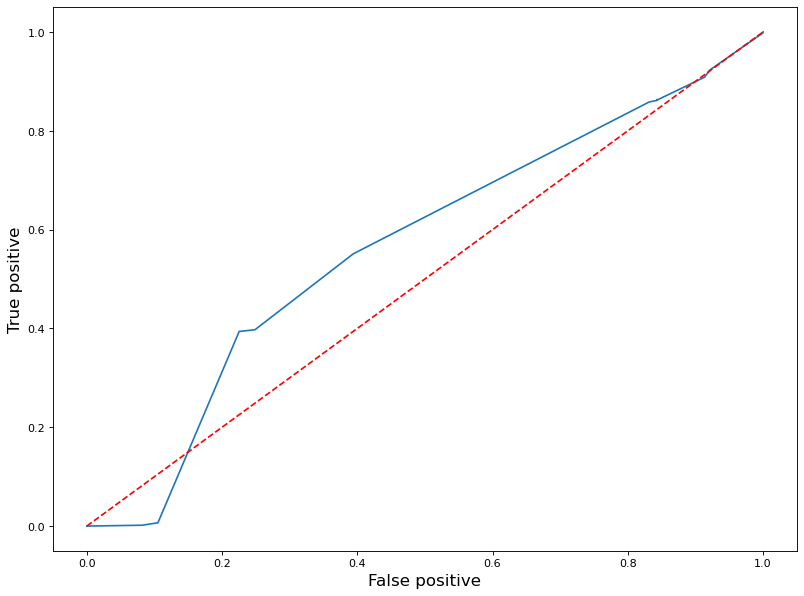

In [17]:
plot.roc_curve(xgb_fpr, xgb_tpr)